In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import os
import warnings

from summer.utils import ref_times_to_dti

from autumn.core.project import get_project, load_timeseries
from autumn.settings.constants import COVID_BASE_DATETIME
from autumn.core.runs import ManagedRun
from autumn.core.runs.calibration.utils import get_posteriors
from autumn.core.utils.pandas import pdfilt
from autumn.settings.region import Region

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Specify the runs of interest

In [3]:
run_id = "sm_sir/bhutan/1653981877/2084dbc"
region = "bhutan"

In [4]:
mr = ManagedRun(run_id)

In [5]:
# full_run = mr.full_run.get_derived_outputs()
pbi = mr.powerbi.get_db()
targets = pbi.get_targets()
results = pbi.get_uncertainty()
mcmc_params = mr.calibration.get_mcmc_params()

## Calibration parameters are:

In [6]:
list(mcmc_params.columns)

['contact_rate',
 'infectious_seed',
 'mobility.microdistancing.behaviour.parameters.max_effect',
 'sojourns.active.total_time',
 'sojourns.latent.total_time']

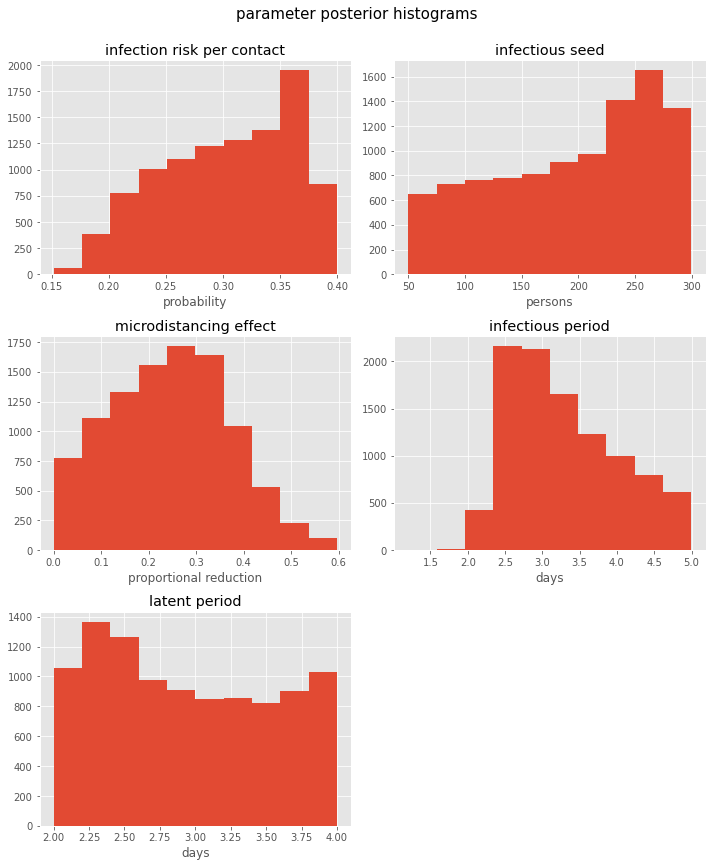

In [7]:
plt.style.use("ggplot")

param_lookup = {
    "contact_rate": "infection risk per contact",
    "infectious_seed": "infectious seed",
    "mobility.microdistancing.behaviour.parameters.max_effect": "microdistancing effect",
    "sojourns.active.total_time": "infectious period",
    "sojourns.latent.total_time": "latent period",
}

unit_lookup = {
    "contact_rate": "probability",
    "infectious_seed": "persons",
    "mobility.microdistancing.behaviour.parameters.max_effect": "proportional reduction",
    "sojourns.active.total_time": "days",
    "sojourns.latent.total_time": "days",
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12))
for i_ax, axis in enumerate(axes.reshape(-1)):
    if i_ax < 5:
        param = mcmc_params.columns[i_ax]
        axis.hist(mcmc_params[param])
        axis.set_title(param_lookup[param])
        axis.set_xlabel(unit_lookup[param])
    if i_ax == 5:
        axis.set_axis_off()

fig.suptitle("parameter posterior histograms", fontsize=15, y=1)
fig.tight_layout()

## Available model outputs are:

In [23]:
project = get_project("sm_sir", region, reload=True)

### Get all targets, including those not used in calibration, to use as a validation

In [9]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
model, country, run, commit = run_id.split("/")
project_file_path = os.path.join(project_root, "autumn", "projects", model, country, country, "timeseries.json")
all_targets = load_timeseries(project_file_path)
for target in all_targets:
    all_targets[target].index = ref_times_to_dti(COVID_BASE_DATETIME, all_targets[target].index)

In [27]:
title_lookup = {
    "notifications": "daily notifications",
    "infection_deaths": "COVID-19-specific deaths",
    "hospital_admissions": "new daily hospital admissions",
    "icu_admissions": "new daily admissions to ICU",
    "proportion_seropositive": "proportion recovered from COVID-19",
    "incidence": "daily new infections",
    "prop_incidence_strain_delta": "proportion of cases due to Delta",
    "hospital_admissions": "daily hospital admissions",
    "hospital_occupancy": "total hospital beds",
    "icu_admissions": "daily ICU admissions",
    "icu_occupancy": "total ICU beds",
    "prop_ever_infected": "ever infected with Delta or Omicron",
    "cdr": "case detection rate",
}

colours = (
    (0.2, 0.2, 0.8), 
    (0.2, 0.8, 0.2), 
    (0.8, 0.2, 0.2), 
    (0.8, 0.8, 0.2), 
    (0.8, 0.2, 0.8), 
    (0.2, 0.8, 0.8), 
    (0.8, 0.8, 0.8),
)
outputs = (
    "notifications", 
    "cdr",
    "hospital_admissions",
    "hospital_occupancy",
    "icu_admissions", 
    "icu_occupancy",
    "prop_ever_infected",
    "incidence",
)

In [33]:
def plot_outputs(outputs, left_date):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex="all")
    for i_ax, axis in enumerate(axes.reshape(-1)):
        output = outputs[i_ax]
#         for scenario in [0, 1, 4]:
        for scenario in [0, 2, 5]:
            colour = colours[scenario]
            results_df = results[(output, scenario)]
            indices = results_df.index
            interval_label = "baseline" if scenario == 0 else project.param_set.scenarios[scenario - 1]["description"]
            scenario_zorder = 10 if scenario == 0 else scenario
            axis.fill_between(
                indices, 
                results_df[0.025], results_df[0.975], 
                color=colour, 
                alpha=0.5,
                label="_nolegend_",
                zorder=scenario_zorder,
            )
            axis.fill_between(
                indices, 
                results_df[0.25], results_df[0.75], 
                color=colour, alpha=0.7, 
                label=interval_label,
                zorder=scenario_zorder
            )
            axis.plot(indices, results_df[0.500], color=colour)
            if output in all_targets and len(all_targets[output]) > 0:
                all_targets[output].plot.line(
                    ax=axis, 
                    linewidth=0., 
                    markersize=8.,
                    marker="o",
                    markerfacecolor="w",
                    markeredgecolor="w",
                    alpha=0.2,
                    label="_nolegend_",
                    zorder=11,
                )
            if output in targets:
                targets[output].plot.line(
                    ax=axis, 
                    linewidth=0., 
                    markersize=5., 
                    marker="o", 
                    markerfacecolor="k",
                    markeredgecolor="k",
                    label="_nolegend_",
                    zorder=12,
                )
            axis.tick_params(axis="x", labelrotation=45)
            axis.set_xlim(left=left_date, right=datetime.date(2022, 10, 1))
            axis.set_title(title_lookup[output])
        if i_ax == 0:
            axis.legend()
    fig.tight_layout()

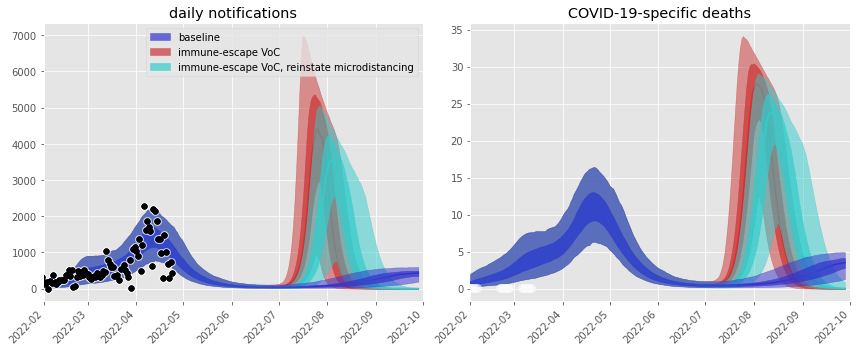

In [34]:
outputs_to_plot = (
    "notifications", 
    "infection_deaths",
    "hospital_admissions",
    "icu_occupancy",
)
plot_outputs(outputs_to_plot, datetime.date(2022, 2, 1))